Which object do you use to generate data ?
Sel


|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| ETA:  00:00:00 |<<<<<<<<<<<<<<<<<<<<<<<<<<<<<|

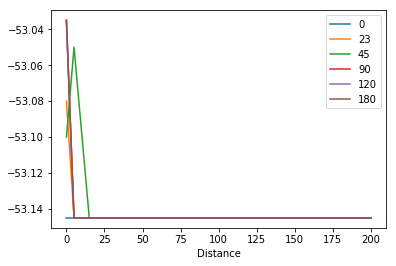

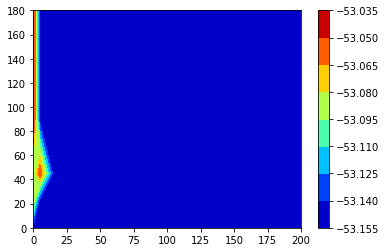

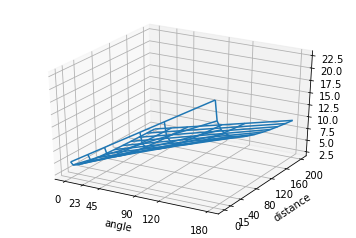

In [6]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import datetime
import pandas_datareader as pdr
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import glob, os
import time
import sys
import inspect

from progressbar import AnimatedMarker, Bar, BouncingBar, Counter, ETA, \
    AdaptiveETA, FileTransferSpeed, FormatLabel, Percentage, \
    ProgressBar, ReverseBar, RotatingMarker, \
SimpleProgress, Timer

#fonction qui renvoie le bon path
def getPath() :
    
    #Renvoie le path courant aussi
    #print(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))))

    #Path courant
    cwd = os.getcwd()
    #C:\Users\laure\WebSocketClientCSharp\WebSocketClient\generate

    #On va changer de path (cwd, '../WebSocketClient/bin/Debug/xp/'))
    os.chdir('../xp/')
    
    #print("Path changed. New path is : "+ os.getcwd())

    return;

# ------------------- CREATION FICHIER FINAL : CONTIENT TOUTES LES MOYENNES ----------------
def finalDataExist() :
    #On va remplir le fichier final : tester s'il existe
    #Si le fichier n'existe pas on le crée
    
    if os.path.isfile('data/finalData.csv') is True:
        os.remove('data/finalData.csv')
    
    #On le créer
    open('data/finalData.csv', 'a').close()        
        
    #On écrit le nom des colonnes
    with open('data/finalData.csv', 'a') as the_file:
        the_file.write('Distance;0;23;45;90;120;180')
        the_file.write('\n')
    #else:
        
    return;

# ------------------- VERIFICATION S'IL EXISTE LES DONNEES NECESSAIRES POUR LES GRAPHS ----------------
def verifyFiles() :

    answer = input("Which object do you want to use to generate data ?\n")
    
    if answer == '__pycache__':
        print("Do not try to fool me !")
        sys.exit("Wrong directory")
        
    if os.path.isdir(answer):
        
        numfiles = len([f for f in os.listdir(answer) if os.path.isfile(os.path.join(answer, f)) and f[0] != '.'])        
        
        #Le nombre total de fichiers csv
        if numfiles != 78:
            sys.exit("Not enough data ! Make sure you collected all the necessary data before you execute this script")
        else:
            os.chdir(answer)
            #print(os.getcwd())
        
    else:
        sys.exit("The data's object doesn't exist. Make sure you collected all the necessary data before you execute this script")

    
    return;

#Fonction permettant de delete tous les graphs et images
def clearAll() :
    
    folders = ['data/2d','data/3d','data/2ddistanceangle','data/heatmap']
    
    for temp in folders:
    
        for the_file in os.listdir(temp):
            file_path = os.path.join(temp, the_file)
        
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
        
                #elif os.path.isdir(file_path): shutil.rmtree(file_path)
            except Exception as e:
                print(e)
    
    return;
    
def generationHeatMap() :
    
    #Separé par des ; donc l'index est la première colonne
    df = pd.read_csv('data/finalData.csv',sep=';',index_col=0)

    #notre X sera l'index : la distance
    x = df.index

    #notre Y sera l'index : la distance
    y = df.columns.astype(int)

    df.values.astype(float)
    z = df.values

    X,Y = np.meshgrid(x,y)
    Z = z.T
    plt.contourf(X,Y,Z,cmap='jet')

    plt.colorbar()
    plt.savefig('data/heatmap/{}.png'.format('heatmap'))

    plt.show()
    plt.close()
    

    return;

def generation2DDistanceAngle() :
    
    #Separé par des ; donc l'index est la première colonne
    df = pd.read_csv('data/finalData.csv',sep=';',index_col=0)

    #print(df)

    df=df.astype(float)
    
    fig = df.plot().get_figure()
    fig.savefig("data/2ddistanceangle/output.png")
    plt.show()
    plt.close(fig)
    
    return;

def generationWireFrame() :
    
    raw_data = np.loadtxt('data/finalData.csv', delimiter=';', dtype=np.string_)

    angle    = raw_data[0 , 1:].astype(float)
    distance = raw_data[1:, 0 ].astype(float)
    data     = raw_data[1:, 1:].astype(float)


    #Données à l'intérieur de la matrice
    data = (50 + angle[np.newaxis,:]) / (10 + np.sqrt(distance[:,np.newaxis])) 

    #Setup du plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    #Créer les données que le wireframe souhaite
    Z = data
    X, Y = np.meshgrid(angle, distance)

    ax.plot_wireframe(X, Y, Z)

    #Legendes
    ax.set_xticks(angle)
    ax.set_yticks(distance[::2])
    ax.set_xlabel('angle')
    ax.set_ylabel('distance')

    #On la'ffiche et on l'enregistre
    plt.savefig('data/3d/3d.png')
    plt.show()
    
    return;

def setupBar() :
    widgets = [Bar('>'), ' ', ETA(), ' ', ReverseBar('<')]
    pbar = ProgressBar(widgets=widgets, maxval=78).start()
    
    return pbar;

#------------------------------------------------------------------
#on va générer les csv des moyennes pour chaque Angle
#On va parcourir tous les CSV ayant la même distance pour un angle
#Faire la moyenne des données dans le fichier CSV
#...
#------------------------------------------------------------------

#IN CASE OF UNINTENDED INTERRUPTION OF THE SCRIPT : PLEASE UNCOMMENT THE NEXT LINE WITH THE GOOD PATH
# ---------- 'C:/path/to/add/WebSocketClientCSharp/WebSocketClient/WebSocketClient/bin/Debug/generate' ----------
#os.chdir('C:/Users/laure/WebSocketClientCSharp/WebSocketClient/WebSocketClient/bin/Debug/generate')

#On change le directory
getPath()

verifyFiles()

#On va nettoyer les potentiels anciens fichiers
clearAll()

#Liste des angles permettant d'effectuer les lectures pour les algo
distances = ['0','5','10','15','25','40','60','80','100','120','140','160','180','200']

finalDataExist()

#On est dans le folder de l'objet courant

#On va setup la progressBar

pbar = setupBar()
ite = 1

for (i, distance) in enumerate(distances):
    #i = index
    #distance = distance courante
    
    #Nous allons stocker les moyennes des RSSI pour chaque couple distance/angle
    averagesRSSI = {}
    
    for file in glob.glob("*.csv"):
        #nom du fichier
        #print(file)
        
        #On sépare le nom du fichier pour savoir si l'angle est le bon
        parts = file.split('_')
        
        #On récupère la distance courante
        #Avec cette distance on va lire tous les fichiers qui concernent cette distance
        #créer une ligne pour append dans le csv final
        
        #Alors on va lire le fichier
        
        if parts[1] == distance:  
            filePath = os.getcwd().replace("\\","/")+"/"+file

            # --------------- CONSTRUCTION GRAPHE 2D RSSI / TIME -------------------------
            
            df = pd.read_csv(filePath,sep=';',index_col=0,parse_dates=True)

            #Moyenne -------------
            #On dit que c'est un float
            df['rssi1'] =df.astype(float)

            #On fait la moyenne de la première colonne
            average = df['rssi1'].mean()
            nb = df.shape[0]
            
            #On enregistre l'average RSSI dans le tableau pour l'append dans le finalData.csv
            #EXEMPLE : Sel_0_0.csv alors averageRSSI[0'°'] = moyenne courante
            #Sel_0_23.csv : averageRSSI[23] = moyenne courante
            #...
            averagesRSSI[file.split('_')[2].split('.')[0]] = average
            
            #On va plot (dessiner) le graph de l'évolution du RSSI selon le temps
            plt.ylabel('RSSI')
            plt.grid(True)
            df['rssi1'].plot()
            
            #On affiche la moyenne dans le plot
            plt.axhline(y=average, color='r', linestyle='-')
            
            temp = file.split('.')[0]
            plt.savefig('data/2d/'+temp+'.png')
            plt.close()
            #Si le fichier n'existe pas on le crée
            if os.path.isfile('data/data.csv') is False:
                open('data/data.csv', 'a').close()
                
                #On écrit le nom des colonnes
                with open('data/data.csv', 'a') as the_file:
                    the_file.write('Nom;Echantillons;Moyenne;EcartType;MoyenneTemps')
                    the_file.write('\n')        
                
            #On écrit les infos
            #Le nom du fichier + nombre d'échantillons + la moyenne + écart type + [autres infos]
            with open('data/data.csv', 'a') as the_file:
                the_file.write(temp+';'+str(nb)+';'+str(average)+';'+'0'+';'+'0')
                the_file.write('\n')
                
            #----------------------------------------------------------------------
            
            #Update de la bar
            pbar.update(ite)
            ite = ite + 1
                
        del parts
    
    #print(averagesRSSI)
    #Maintenant que notre dictionnary des moyennes pour chaque couple Distance / Angle
    
    if bool(averagesRSSI) is True:
        final = distance + ';' + str(averagesRSSI["0"]) + ';'+ str(averagesRSSI["23"]) + ';' + str(averagesRSSI["45"]) + ';' + str(averagesRSSI["90"]) + ';' + str(averagesRSSI["120"]) + ';' + str(averagesRSSI["180"])
        #print(final)
        
        with open('data/finalData.csv', 'a') as the_file:
                the_file.write(final)
                the_file.write('\n')
    
    
    del averagesRSSI


generation2DDistanceAngle()
    
generationHeatMap()

generationWireFrame()

os.chdir('../')
